(rois:loading_3d)=
# Downloading ROIs (3D)

Following up the notebooks about [uploading nD segmentations](rois:saving_3d) as ROIs to OMERO and the previous notebook on [restoring segmentations from uploaded ROIs](rois:loading_2d), let's look at how we can accomplish the same with nD-segmentations.

For this tutorial, you'll have to install napari, too:

```bash
mamba install napari pyqt
```

In [8]:
from omero.model import Shape
from omero.rtypes import unwrap
from typing import Tuple
import ezomero
import napari
import numpy as np

In [ ]:
viewer = napari.Viewer(ndisplay=3)

Let's connect to our server:

In [3]:
user = 'your-user'
group = 'default'
host = 'your-host'
port = 4064
secure = True

conn = ezomero.connect(host=host, port=port, group=group, user=user, password=None, secure=secure)

Let's retrieve the image - again, check the OMERO browser to see the id of the uploaded image, as it will likely differ on your end.

<_ImageWrapper id=38009>
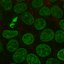

In [4]:
image_id = 38009

image_wrapper, image = ezomero.get_image(conn, image_id, dim_order='tczyx')
image_wrapper

Let's check what ROIs we find attached to this image. In our case, there are two ROIs. One for the binary mask and one for the labels image from the previous tutorial.

In [5]:
rois = image_wrapper.getROIs()
print('Number of ROIs:', len(rois))

Number of ROIs: 34


## Labels images

Let's directly try and recreate some label images from this data. We first allocate and empty label image. Note that we want to restore a 3D segmentation in this case, so we have to build the 3D label objects from the individual ROIs. Luckily, every ROI is explicitly assigned to a specific channel, z-slice and timepoint so that there is not ambiguity. Again, we use the copied `mask_to_binary_image` function from [omero-cli-zarr](https://github.com/ome/omero-cli-zarr) for our purposes here until it has been moved over to the [omero-rois package](https://github.com/ome/omero-rois).

In [9]:
def mask_to_binary_image(
    mask: Shape, dtype=bool
) -> Tuple[np.ndarray, Tuple[int, ...]]:
    """
    Convert an OMERO mask to a binary image
    :param mask MaskI: An OMERO mask
    :param dtype: Data type for the binary image
    :return: tuple of
            - Binary mask
            - (T, C, Z, Y, X, w, h) tuple of mask settings (T, C, Z may be
            None)
    """

    t = unwrap(mask.theT)
    c = unwrap(mask.theC)
    z = unwrap(mask.theZ)

    x = int(mask.x.val)
    y = int(mask.y.val)
    w = int(mask.width.val)
    h = int(mask.height.val)

    mask_packed = mask.getBytes()
    # convert bytearray into something we can use
    intarray = np.fromstring(mask_packed, dtype=np.uint8)
    binarray = np.unpackbits(intarray).astype(dtype)
    # truncate and reshape
    binarray = np.reshape(binarray[: (w * h)], (h, w))

    return binarray, (t, c, z, y, x, h, w)

In [10]:
labels = np.zeros(image.shape, dtype=np.uint16)
labels.shape

(1, 2, 60, 256, 256)

In [11]:
for idx, roi in enumerate(rois):
    shapes = roi.copyShapes()
    for shape in shapes:
        array, metadata = mask_to_binary_image(shape)
        t = metadata[0]
        c = metadata[1]
        z = metadata[2]
        y = metadata[3]
        x = metadata[4]
        h = metadata[5]
        w = metadata[6]

        mask = array == 1
        labels[t, c, z, y:y+h, x:x+w][mask] = idx + 1

Let's see what we get from this:

In [12]:
image.squeeze().shape

(2, 60, 256, 256)

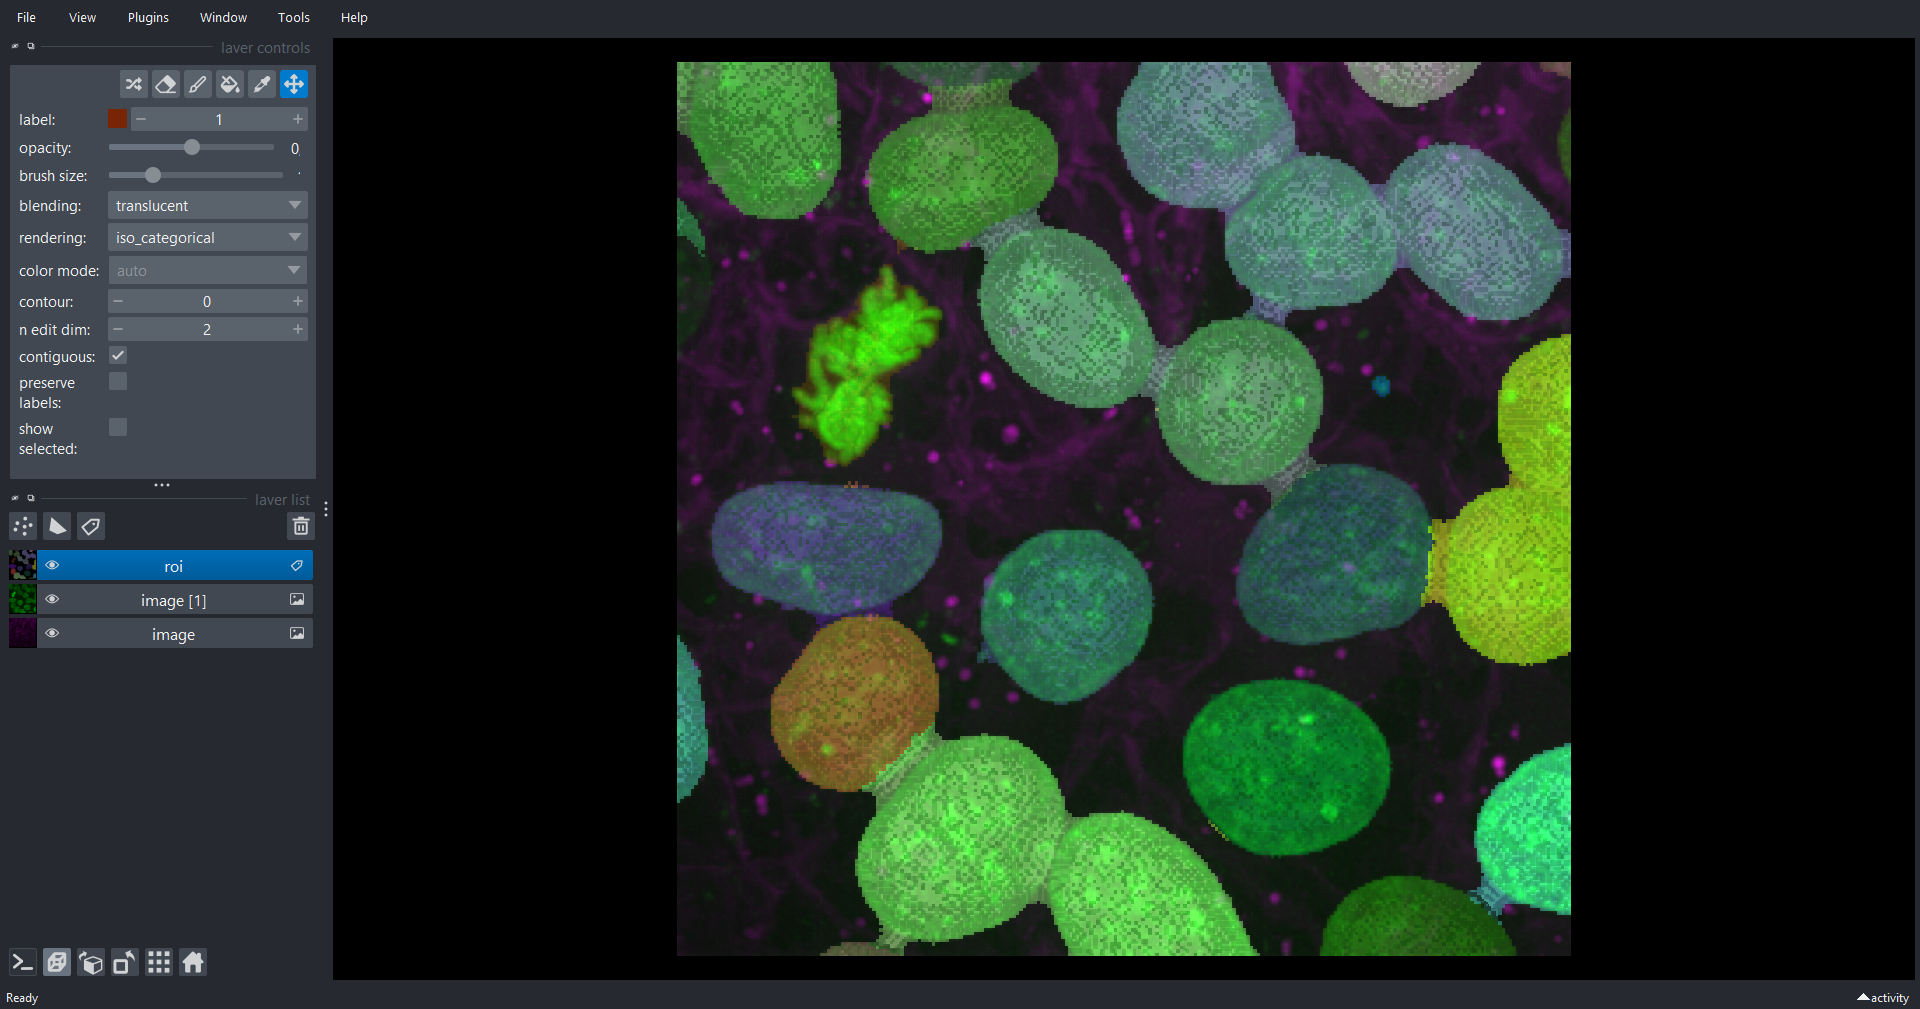

In [13]:
viewer.layers.clear()
viewer.add_image(image.squeeze(), name='image', channel_axis=0)
viewer.add_labels(labels.squeeze()[1], name='roi', opacity=0.5)
napari.utils.nbscreenshot(viewer)

There we go :)